## **Ensemble Methods**

## **Davor Sobin**


### **Introduction**

### **Dataset**
  
The dataset for this assignment contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier
)
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    auc,
    accuracy_score,
    confusion_matrix
)

#### **Utilizing the provided credit card data, we will employ methods from sklearn for cross-validation to estimate error.**

In [2]:
df_cc = pd.read_csv('cc.csv')

In [27]:
df_cc.isnull().values.any()

count_classes = pd.value_counts(df_cc["Class"], sort=True)
count_classes

legit = count_classes[0]
fraud = count_classes[1]
print(f"Legit count: {legit}")
print(f"Fraudulant count: {fraud}")

Legit count: 142167
Fraudulant count: 237


In [28]:
fraud = df_cc[df_cc["Class"] == 1]
legit = df_cc[df_cc["Class"] == 0]

fraud.Amount.describe()

count     237.000000
mean      118.864852
std       224.038331
min         0.000000
25%         1.000000
50%        11.400000
75%       111.700000
max      1504.930000
Name: Amount, dtype: float64

In [29]:
legit.Amount.describe()

count    142167.000000
mean         88.954197
std         252.926782
min           0.000000
25%           5.520000
50%          21.950000
75%          77.340000
max       25691.160000
Name: Amount, dtype: float64

## **Partition the data for cross validation**



Import the dataset and divide it into two parts: 𝑋 (features, stored in `df_X`) and 𝑦 (target, stored in `s_y`). Establish our data partitions.

Given the significant imbalance in the dataset, there's concern about the target class being insufficiently represented in a random k-fold split. To address this, we opt for a [stratified k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) approach, which ensures the preservation of class proportions across our tests. We'll use `𝑘=3`. Create a `StratifiedKFold` instance and utilize its `split` method to fill the training and testing dictionaries.

   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [4]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)


d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()

# Write your code here
for i, (train_index, test_index) in enumerate(skf.split(df_X, s_y)):
  d_train_df_X[f"Fold {i}"] = df_X.loc[train_index]
  d_train_s_y[f"Fold {i}"] = s_y.loc[train_index]
  d_test_df_X[f"Fold {i}"] = df_X.loc[test_index]
  d_test_s_y[f"Fold {i}"] = s_y.loc[test_index]


In [18]:
print(d_train_df_X.keys())
d_train_df_X['Fold 0']
d_train_s_y['Fold 0']

dict_keys(['Fold 0', 'Fold 1', 'Fold 2'])


2         0
3         0
4         0
5         0
6         0
         ..
142396    0
142398    0
142400    0
142402    0
142403    0
Name: Class, Length: 94936, dtype: int64

In [5]:
# Observe the test data and verify that the target training is as equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64


## **Implementing AdaBoost Classifier**

As we learned in class, AdaBoost is a boosting ensemble method that starts with a weak classifier and iteratively adds to it by focusing on the misclassified instances. In many AdaBoost implementations, "Decision Stumps" (decision trees with a single split) are used as the base classifier.

While AdaBoost can work with various base classifiers, the default in `Scikit-learn`'s implementation is `DecisionTreeClassifier(max_depth=1)`, which is essentially a decision stump (a weak classifier).

In this question, you will implement a function called `train_and_plot_adaboost()` that will do the following:

* Model training and prediction: Instantiate the AdaBoost classifier with the specified parameters: `AdaBoostClassifier(n_estimators=25, random_state=23)`

* `fit` to train the model.For predictions, you can use `predict` method for class predictions or `predict_proba` method to get the probability of being in class 0 or class 1. You will do cross-validation by loop over the 𝑘 folds using the dictionaries from the first problem. For each fold, calculate the following metrics:
    * Accuracy
    * True Positive Rate (TPR)
    * Positive Predictive Value (PPV)
    * False Positive Rate (FPR)
    * ROC Curve Plotting:

* Plot the ROC curve for each fold. You may use the roc_curve, RocCurveDisplay, from Scikit-learn. There is a great example in the documentation on plotting ROC curves in cross validation that is helpful.


* After looping through all the folds, save the predictions from the 3rd fold into a variable named `y_hat_ab`. This is the variable your function will return.

* Your function should have a complete docstring.


AdaBoost focuses on instances that were misclassified in previous iterations, which can lead to improved performance. Depending on the data size and the number of estimators, AdaBoost can take some time to run. Please be patient and allow it a few minutes if needed.


Working on Fold 0
Working on Fold 1
Working on Fold 2
The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


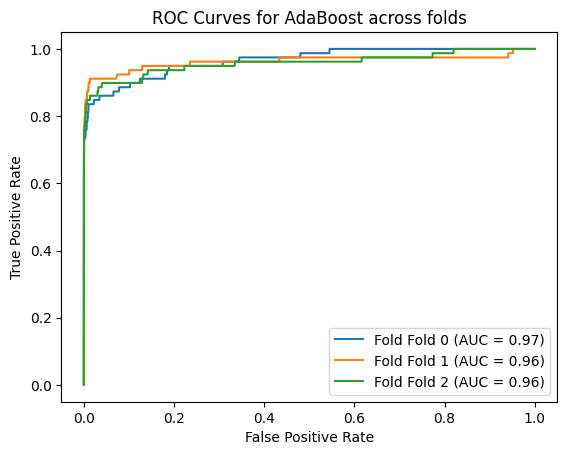

In [6]:
def train_and_plot_adaboost():
  '''
  Trains an AdaBoost classifier using decision stumps as weak learners on provided
  data. Computes accuracy, TPR (True Positive Rate), PPV(Positive Predictive Value),
  and FPR (False Positive Rate) for each fold in cross-validation.
  Plots ROC curve for each fold.
  Parameters:
    - None: Relies on globally defined datasets and split indices
  Data used:
    - d_train_df_X: Dictionary of training data features for each fold
    - d_train_s_y: Dictionary of training data labels for each fold
    - d_test_df_X: Dictionary of validation data features for each fold
    - d_test_s_y: Dictionary of validation data labels for each fold
  Returns:
    - y_had_ab: Predictions for the thrid fold.
  '''
  k = 3
  acc_ab = np.zeros(k)
  tpr_ab = np.zeros(k)
  ppv_ab = np.zeros(k)
  fpr_ab = np.zeros(k)


  fig, ax = plt.subplots()
  y_hat_ab = None

  # Complete this function
  for i, key in enumerate(d_train_df_X.keys()):
      print("Working on {}".format(key))
      clf = AdaBoostClassifier(n_estimators=25, random_state=23)
      clf.fit(d_train_df_X[key], d_train_s_y[key])
      y_score = clf.decision_function(d_test_df_X[key])
      y_pred = clf.predict(d_test_df_X[key])
      fpr, tpr, thresh = roc_curve(d_test_s_y[key], y_score)
      auc_val = auc(fpr, tpr)

      RocCurveDisplay(fpr=fpr,
                      tpr=tpr,
                      roc_auc=auc_val,
                      estimator_name=f"Fold {key}").plot(ax=ax)
      acc_ab[i] = accuracy_score(d_test_s_y[key], y_pred)
      tn, fp, fn, tp = confusion_matrix(d_test_s_y[key], y_pred).ravel()
      tpr_ab[i] = tp / (tp+fn)
      fpr_ab[i] = fp / (fp+tn)
      ppv_ab[i] = tp / (tp+fp)


      if key == "Fold 2":
        y_hat_ab = y_pred




  print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
  print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
  print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))


  # plot the ROC Curve
  plt.title("ROC Curves for AdaBoost across folds")
  plt.show()

  return y_hat_ab


y_hat_ab = train_and_plot_adaboost()


### **Implementing The Random Forest Classifier and Testing Its Performance**

Random Forest is an ensemble method that constructs a multitude of decision trees during training. For predictions, the mode of the classes (classification) of individual trees is used. The trees are built completely with no pruning. Hence, every leaf in the tree will be pure, but individual trees might be overfitted to the training set.

In this question, you will implement a function called `train_and_plot_randomforest()` where you will implement the following:

* While building the decision trees, at every internal node, randomly select 𝑝 attributes. Identify the best split that minimizes impurity among these 𝑝 attributes. The parameter 𝑝 corresponds to the `max_features` parameter in the `Scikit-learn`'s Random Forest Classifier.

**Model Training**
* Instantiate the Random Forest classifier with the specified parameters:
`RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)`. `fit` to train the model. For predictions, you can use `predict` method for class predictions. `predict_proba` method to get the probability of being in class 0 or class 1. These probabilities are used when creating ROC curves.

**Cross Validation**

* Loop over the 𝑘 folds using the dictionaries from the first problem.
For each fold, calculate the following metrics:
* Accuracy
* True Positive Rate (TPR)
* Positive Predictive Value (PPV)
* False Positive Rate (FPR)

**ROC Curve Plotting**

* Using the probabilities obtained from `predict_proba`, compute the ROC values.
* Plot the ROC curve for each fold. You can utilize the `RocCurveDisplay` from `Scikit-learn`.
* Refer to the Scikit-learn documentation for an example on plotting ROC curves in cross-validation.

**Saving Predictions**

* After looping through all the folds, save the predictions from the 3rd fold into a variable named `y_hat_rf`. This is what your function will return.



Working on Fold 0
Working on Fold 1
Working on Fold 2
The min, mean, and max TPR are: 0.75, 0.78, and 0.80
The min, mean, and max PPV are: 0.92, 0.93, and 0.95
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


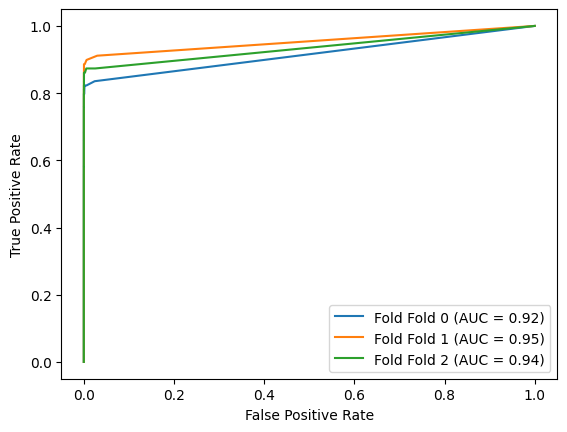

In [7]:
def train_and_plot_randomforest():
    '''
    Trains a Random Forest classifier on the provided training data and plots the ROC curve
    for each fold in the cross-validation process.

    The function uses a Random Forest with specified hyperparameters. For each fold in the
    cross-validation, the function computes accuracy, TPR, PPV, and FPR, and plots the
    corresponding ROC curve. The ROC curve is generated using the class probabilities
    for the positive class from the Random Forest classifier.

    Parameters:
    None. The function relies on globally defined datasets and split indices.

    Returns:
    y_hat : numpy array
        Predictions for the instances in the test set for the 3rd fold.

    Note:
    This function assumes that certain variables like training and test sets are
    defined in the global namespace.
    '''
    k = 3
    acc_rf = np.zeros(k)
    tpr_rf = np.zeros(k)
    ppv_rf = np.zeros(k)
    fpr_rf = np.zeros(k)

    fold_count = 0
    fig, ax = plt.subplots()
    y_hat_rf = None

    # Complete this function
    for i, key in enumerate(d_train_df_X.keys()):

        print("Working on {}".format(key))

        # Train RandomForest classifier
        clf = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
        clf.fit(d_train_df_X[key], d_train_s_y[key])
        pred = clf.predict(d_test_df_X[key])


        # Get the probability scores for the positive class
        pred_prob = clf.predict_proba(d_test_df_X[key])[:, 1]

        # Compute the ROC values
        fpr, tpr, thresh = roc_curve(d_test_s_y[key], pred_prob)


        # Compute the AUC (Area Under the Curve)
        auc_val = auc(fpr, tpr)


        # Plot the ROC curve using RocCurveDisplay
        RocCurveDisplay(fpr=fpr,
                        tpr=tpr,
                        roc_auc=auc_val,
                        estimator_name=f"Fold {key}").plot(ax=ax)



        # Accuracy
        acc_rf[i] = accuracy_score(d_test_s_y[key], pred)


        tn, fp, fn, tp = confusion_matrix(d_test_s_y[key], pred).ravel()
        # True positive rate

        tpr_rf[i] = tp / (tp+fn)
        fpr_rf[i] = fp / (fp+tn)
        ppv_rf[i] = tp / (tp+fp)


        if key == "Fold 2":
          y_hat_rf = pred



                                                                                                          # add epsilon to avoid division by zero



    print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
    print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
    print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

    #plot the ROC curve

    plt.show()

    return y_hat_rf


y_hat_rf = train_and_plot_randomforest()

### **Calculate the Cost of Fraud**

In the above problems, we saved the predictions of the 3rd fold into the variables `y_hat_ab` and `y_hat_rf` for the AdaBoost and RandomForest models respectively.

Now, the Bank wants you to tell them how much money they are going to save if they deploy either of these fraud algorithms to the real-time payment processing system.  Assume that there is not a currently deployed fraud detection algorithm.  

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice that much money.  So, a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction.

Using the 3rd fold test sample, calculate how much money the Bank will save with each algorithm, and make a recommendation of which algorithm to deploy to production. All amounts are given in Euros.

In [30]:
# First, calculate the current cost to the bank with no fraud decection
fold_3_amount = d_test_df_X["Fold 2"]['Amount']
current_cost = fold_3_amount[d_test_s_y["Fold 2"] == 1].sum()*2.0
print("The current cost to the bank is €{:.2f}".format(current_cost))

The current cost to the bank is €22484.74


In [31]:
# FN and FP for AdaBoost
fn_mask_ab = (d_test_s_y["Fold 2"] == 1) & (y_hat_ab == 0)
fp_mask_ab = (d_test_s_y["Fold 2"] == 0) & (y_hat_ab == 1)

In [32]:
# Write your code here
cost_ab_undetected_fraud = fold_3_amount[fn_mask_ab].sum() * 2.0
cost_ab_false_fraud = fp_mask_ab.sum() * 3
print("The bank will save €{:.2f} by deploying the AdaBoost algorithm".format(current_cost-cost_ab_undetected_fraud-cost_ab_false_fraud))

The bank will save €13946.42 by deploying the AdaBoost algorithm


In [33]:
# FN and FP for ForestRegression
fn_mask_rf = (d_test_s_y["Fold 2"] == 1) & (y_hat_rf == 0)
fp_mask_rf = (d_test_s_y["Fold 2"] == 0) & (y_hat_rf == 1)

In [34]:
# Write your code here
cost_rf_undetected_fraud = fold_3_amount[fn_mask_rf].sum() * 2.0
cost_rf_false_fraud = fp_mask_rf.sum() * 3
print("The bank will save €{:.2f} by deploying the Random Forest algorithm".format(current_cost-cost_rf_undetected_fraud-cost_rf_false_fraud))

The bank will save €18121.36 by deploying the Random Forest algorithm


#**Which Model should the bank deploy?**
When we're considering which model the bank should deploy in prouduction between AdaBoost and RandomForest, a key factor is the balance between computational efficiency and prediction accuracy, especially in the context of fraud detection.



*   **AdaBoost**: AdaBoost is a very attractive option for systems where computational resources are limited or when rapid decision-making is critical. For a bank that values quick transaction processing and has a high volume of transactions to assess in real-time, the speed of AdaBoost could be a significant benefit. However, AdaBoost might be more sensitive to noisy data and outliers, which are not uncommon in financial datasets, potentially leading to a higher rate of false positives or negatives compared to other more sophisticated models.
*   **RandomForest**: RandomForest on the other hand, is known to be more accurate, robuts and able to handle non-linear data more effectively. It is less prone to overfitting than AdaBoost and can provide more accurate results, especially in complex fraud detection scenarios where interactions between variables are non-linear and subtle. The downside, however, is that RandomForest requires more computational power and time to train and make predictions, due to the complextiy of constructing and evaluating multiple trees.

Given these considerations, while **AdaBoost** offers the advantage of speed and efficiency, which is crucial for real-time fraud detection in a fast-paced banking environment, **RandomForest** provides superior accuracy and robustness, which could lead to better detection of fraudulent transactions

**In conclusion**: While AdaBoost does offer speed and efficiency, the bank should consider deploying **RandomForest** in production for its fraud detection needs. The argument here is straightforward: the additional savings from the superior accuracy of RandomForest - by more effectively identifying fraudulent transactions and reducing the costs associated with misclassifications - outweighs the benefits of the speed and efficiency provided by AdaBoost. In the context of fraud detection, where financial stakes are high, investing in more accurate, albeit computationally intensive, models like RandomForest could result in substantial net savings and more secure banking environment for customers.

